# Dollar Cost Averaging vs Dollar Cost Averaging when Market is Down

In [2]:
import math
import time
import statistics
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
yf.pdr_override()

indicies = ["^AXJO", "^SP500TR", "^IXIC", "^DJI", "^BUK100P", "^FTSE", "^N100", "^NYA", "^RUT", "^GDAXI", "^FCHI", "^STOXX50E", "^AORD"]

startYear = 2000
startMonth = 1
startDay = 20

start = dt.datetime(startYear, startMonth, startDay)
now = dt.datetime.now()
#df = pdr.get_data_yahoo(ETF, start, now)


# The Thesis
##### You can get higher returns from investing in the market portolio while everyone hates it. Always hear people say this.
# The Test
##### Invest 1000 every month into an index. If the price of the index is below the selected moving average then invest 1000 into another account too.
##### Start from as early as possible and start new tests every year. Years = 360 days, months = 30 days, all in trading days...
##### If account one's average returns are lower than account two's than those who advocate this thesis are correct.

## Account Return Formula
##### The sum of all returns (continuously compounded) divided by the number of years that particular initial investment was in for. This is divided by the ammount of initial investments. 
##### In other words, it is the arithmitic average of the natural log of the yearly gross discrete returns.
$\huge
r_A = \frac{\sum_{i = 1}^{n}{(ln(\frac{V_e}{V_s}) \div n)}}{i}
$
##### where V = value, e = end, s = start, n = years since initial investment, i = number of investments

In [4]:
df = pdr.DataReader(indicies, data_source='yahoo', start='2006-01-15', end=now)
df.drop(df.iloc[:, 13:], inplace = True, axis = 1)
rows = df.shape[0]
accounts = pd.DataFrame(index=range(int(rows/30)), columns=['Acc 1 Vs', 'Acc 1 Hs', 'Acc 1 Ve', 'LGDR1/n', 'AA(LGDR1/n)', 'Acc 2 Vs', 'Acc 2 Hs', 'Acc 2 Ve', 'LGDR2/n', 'AA(LGDR2/n)'])
results = pd.DataFrame(index=range(15), columns=['Name', 'AA(LGDR1/n)', 'AA(LGDR2/n)']).fillna(0.00)

[*********************100%***********************]  13 of 13 completed


In [17]:
#test each index:
index = 0
while index < len(indicies):
    data = pd.DataFrame(data = df.iloc[:, index])
    data = data.dropna()
    data["sma"] = data.iloc[:, 0].rolling(window=100).mean()
    
    rows = data.shape[0]
    accounts = pd.DataFrame(index=range(int(rows/30)), columns=['Acc 1 Vs', 'Acc 1 Hs', 'Acc 1 Ve', 'LGDR1/n', 'AA(LGDR1/n)', 'Acc 2 Vs', 'Acc 2 Hs', 'Acc 2 Ve', 'LGDR2/n', 'AA(LGDR2/n)'])
    
    #Variables
    days = 0
    totalDays = rows - 1
    month = 30 ##reinvest after 
    months = 12
    cf = 1000

    def invest():
        accounts["Acc 1 Hs"][days/month] = cf / data.iloc[days, 0]
        accounts["Acc 1 Vs"][days/month] = cf

        if data.iloc[days, 1] < data.iloc[days, 0]: #bull
            accounts["Acc 2 Hs"][days/month] = 0 
            accounts["Acc 2 Vs"][days/month] = 0

        else: #bear
            accounts["Acc 2 Hs"][days/month] = cf / data.iloc[days, 0]
            accounts["Acc 2 Vs"][days/month] = cf

    #for every row(day) in stock data
    for i in data.index:
        if days < totalDays: 
            if days % month == 0 or days == 0: 
                invest() #Monthly investment
            
        days += 1  
    
    #accounts end values
    monthsS = accounts.shape[0]
    sumR2 = 0
    countR2 = 0
    for i in accounts.index:
        accounts["Acc 1 Ve"][i] = data.iloc[-1, 0] * accounts["Acc 1 Hs"][i]
        accounts["Acc 2 Ve"][i] = data.iloc[-1, 0] * accounts["Acc 2 Hs"][i]
        accounts["LGDR1/n"][i] = math.log(accounts["Acc 1 Ve"][i]/accounts["Acc 1 Vs"][i])/((monthsS-i)/12)

        if accounts["Acc 2 Hs"][i] > 0:
            accounts["LGDR2/n"][i] = math.log(accounts["Acc 2 Ve"][i]/accounts["Acc 2 Vs"][i])/((monthsS-i)/12)
            sumR2 += accounts["LGDR2/n"][i]
            countR2 += 1

    R1 = accounts["LGDR1/n"].sum()/accounts.shape[0]*100
    R2 = sumR2/countR2*100
    accounts["AA(LGDR1/n)"] = R1/100
    accounts["AA(LGDR2/n)"] = R2/100
    
    results['Name'][index] = data.columns[0][1]
    results['AA(LGDR1/n)'][index] = R1
    results['AA(LGDR2/n)'][index] = R2
    
    if index == df.shape[1]-1: #change the -1 to -n to go to which index you want
        break
    else:
        index += 1

results['outperformance?'] = results['AA(LGDR2/n)'] - results['AA(LGDR1/n)']

print("Annualised Returns")
print("Average outperformance: ", round(results['outperformance?'].mean(), 2), "%")
print("Max outperformance: ", round(results['outperformance?'].max(), 2), "%")
print("Min outperformance: ", round(results['outperformance?'].min(), 2), "%")

Annualised Returns
Average outperformance:  0.51 %
Max outperformance:  1.63 %
Min outperformance:  -1.64 %


In [15]:
results

,Name,AA(LGDR1/n),AA(LGDR2/n),outperformance?
0,^AORD,8.400045,8.512099,0.112055
1,^AXJO,7.551386,7.915729,0.364343
2,^BUK100P,3.778702,4.667055,0.888353
3,^DJI,16.057045,16.430623,0.373578
4,^FCHI,12.122349,13.196965,1.074616
5,^FTSE,3.852202,5.206554,1.354352
6,^GDAXI,12.154805,13.787037,1.632232
7,^IXIC,28.474749,26.837751,-1.636998
8,^N100,11.779529,13.055000,1.275471
9,^NYA,12.431222,13.503038,1.071817


# Graphs
##### To change the index you want to view, set the break to where the script will stop at that index above. It's commented above too.

## Returns

Text(0, 0.5, 'Return')

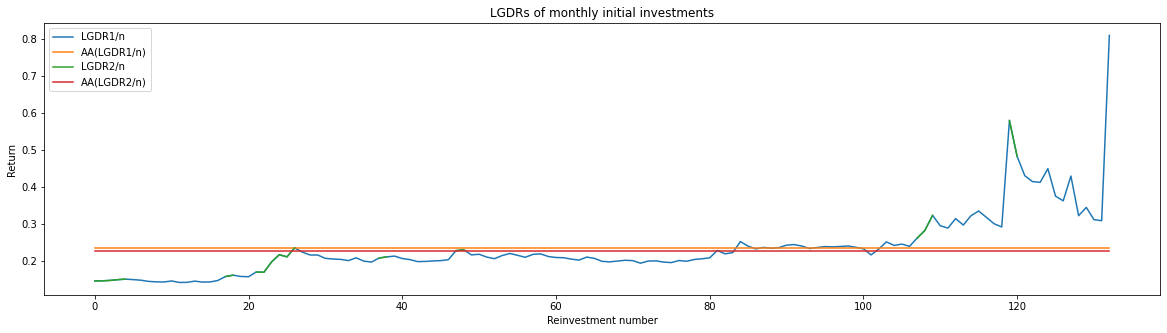

In [24]:
data = accounts.iloc[0:, [3,4,8,9]]
a = data.plot(title='LGDRs of monthly initial investments', figsize=(20,5))

#plt.yscale("log")
plt.xlabel("Reinvestment number")
plt.ylabel("Return")

##### I think the reason its going up so much at the end is because the returns are annualised so if you have a really good month at the end then it calculates the annualised return to be really high.

## Index Price

Text(0, 0.5, 'Return')

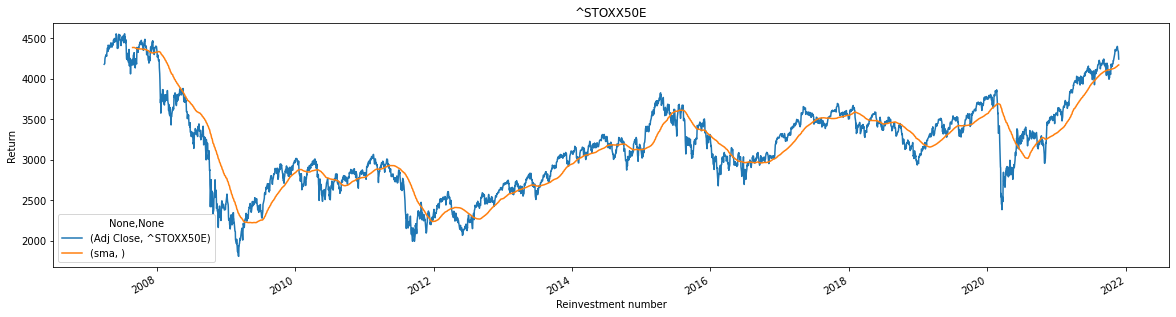

In [30]:
data = data
Index = data.columns[0][1]
a = data.plot(title=Index, figsize=(20,5))

#plt.yscale("log")
plt.xlabel("Reinvestment number")
plt.ylabel("Return")

# Conclusion
##### Account two's average returns outperform account one's average returns by a small ammount. In the sample tested here, account two outperformed account one by 0.52% per year on average accross the different indicies. When you change the condition to invest while market is trading above the moving average, account two underperforms account one by 0.57% per year in the sample tested. This shows that there is some truth to the argument. Just keep to your dollar cost averaging schedule and double down if you're feeling lucky lol. 
##### Further testing: investing daily while market is down.